In [1]:
using CSV, DataFrames, JuMP, Gurobi, Plots, HDF5, JLD

In [2]:
# Some constants for the model

# R: hospitalization rates.
# 2x3 (age group x dose group)
# first row for ppl below 65 and second row for ppl above 65
# first to third column: 1, 2, and 0 doses of vaccine
R = Matrix([0.02 0.01 0.1; 0.05 0.01 0.25]) 
gamma = 0.1 # State can only vaccinate 10% of population per week

0.1

In [3]:
data_folder = "real_world_data"
# Load csv files
case_file_g1 = data_folder * "/" * "case_data_g1.csv"
case_file_g2 = data_folder * "/" * "case_data_g2.csv"
population_file = data_folder * "/" * "population_data_age.csv"
vaccine_file = data_folder * "/" * "vaccine_data.csv"

case_data_g1 = CSV.read(case_file_g1, DataFrame)
case_data_g2 = CSV.read(case_file_g2, DataFrame)
population_data = CSV.read(population_file, DataFrame)
vaccine_data = CSV.read(vaccine_file, DataFrame)

P = Matrix(population_data)
CG1 = Matrix(case_data_g1)
CG2 = Matrix(case_data_g2)
V = Matrix(vaccine_data)
# convert population data to matrix

CG1 = CG1'
CG2 = CG2'
C = cat(CG1, CG2, dims=3)
P = P[:,2:3]
V = V[:,1]

println("C: ", size(C))
println("P: ", size(P))
println("V: ", size(V))

n_states = 1:size(case_data_g1, 2)
n_weeks = 1:size(case_data_g1, 1) 
n_weeks_2 = 1:size(case_data_g1, 1)-1 

n_groups = 1:size(P, 2)
n_doses = 1:3

total_states = length(n_states) 
total_weeks = length(n_weeks) 
println("Number of states: ", n_states)
println("Number of weeks: ", n_weeks)
println("Number of groups: ", n_groups)
println("Number of dose groups: ", n_doses)

C: (50, 52, 2)
P: (50, 2)
V: (52,)
Number of states: 1:50
Number of weeks: 1:52
Number of groups: 1:2
Number of dose groups: 1:3


In [10]:
model = Model(Gurobi.Optimizer)

@variable(model, X[n_states, n_weeks, n_groups, n_doses] >= 0);
@variable(model, W[n_states, n_weeks, n_groups, n_doses] >= 0);
@variable(model, Y[n_states, n_weeks] >= 0);

@objective(model, Min, sum(sum(Y[i,j] for i in n_states) for j in n_weeks));

@constraint(model, hospitalizations[i in n_states, j in n_weeks],
       Y[i,j] == sum(sum(C[i,j,g] * W[i,j,g,d] * R[g,d] for g in n_groups) for d in n_doses)
)

@constraint(model, initial_vax_frac[i in n_states, g in n_groups, d in n_doses],
       W[i,1,g,d] == 0) 

@constraint(model, frac_bounds[i in n_states, j in n_weeks, g in n_groups, d in n_doses],
       W[i,j,g,d] <= 1)

@constraint(model, vax_frac[i in n_states, j in n_weeks_2, g in n_groups, d in 1:2],
       W[i,j+1,g,d] == W[i,j,g,d] + X[i,j,g,d] / P[i,g]) 

@constraint(model, novax_frac[i in n_states, j in n_weeks_2, g in n_groups],
       W[i,j+1,g,3] == 1 - W[i,j,g,1] - W[i,j,g,2])

@constraint(model, num_vax2_c1[i in n_states, j in 1:5, g in n_groups],
       X[i,j,g,2] == 0) 

@constraint(model, num_vax2_c2[i in n_states, j in 6:size(n_weeks)[1], g in n_groups],
       X[i,j,g,2] <= sum(X[i,k,g,1] for k in 1:j-5) - sum(X[i,k,g,2] for k in 1:j-1)) 

@constraint(model, vax_supply[j in n_weeks],
       sum(sum(sum(X[i,j,g,d] for i in n_states) for g in n_groups) for d in n_doses) <= V[j]) 

@constraint(model, state_vax_capacity[i in n_states, j in n_weeks],
       sum(sum(X[i,j,g,d] for g in n_groups) for d in n_doses) <= gamma * (P[i,1] + P[i,2]));

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-18


In [12]:
optimize!(model)
objective_value(model)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 41652 rows, 33800 columns and 360800 nonzeros
Coefficient statistics:
  Matrix range     [3e-08, 7e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.073731126e+06

User-callback calls 18, time in user-callback 0.00 sec


2.0737311256401937e6

In [14]:
W = value.(W)
X = value.(X)
Y = value.(Y);

# X_soln = zeros(total_states, total_weeks)
# Y_soln = zeros(total_states, total_weeks)
# W_soln = zeros(total_states, total_weeks)
# # Compute distances between all pairs of points
# for i in n_states
#     for j in n_weeks
#         X_soln[i,j] = X[i,j]
#         Y_soln[i,j] = Y[i,j]
#         W_soln[i,j] = W[i,j]
#     end
# end

# # save the solutions as a jld file
# save("solution_real.jld", "X_soln", X_soln, "Y_soln", Y_soln, "W_soln", W_soln)

In [15]:
Y

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:50
    Dimension 2, 1:52
And data, a 50×52 Matrix{Float64}:
 0.0   4968.6    6672.95   3783.05   …    57.39    103.635   130.8
 0.0    397.1     466.75    497.425       48.105    42.33     34.17
 0.0   9514.77   8753.4    9437.15       563.415   780.135   609.81
 0.0   3716.17   2742.4    2728.15       106.065   154.11    134.835
 0.0  67525.7   45263.9   17954.8       1436.05   2219.89   1961.58
 0.0   3114.05   3656.4    4093.75   …   460.515   448.56    335.7
 0.0   2885.8    3839.58   2976.1        169.395   291.21    506.52
 0.0    991.7    1352.4     734.6         74.73    110.265   118.59
 0.0  16426.1   18338.3   23977.1        267.99    305.28    382.485
 0.0  11579.4    8430.45   9764.95       184.17    259.545   302.46
 0.0    151.5     249.45    300.45   …    16.23     19.695    42.345
 0.0   1322.7    1404.8    1537.25        66.87     85.2      65.445
 0.0   8399.65   9883.4   11496.2        8

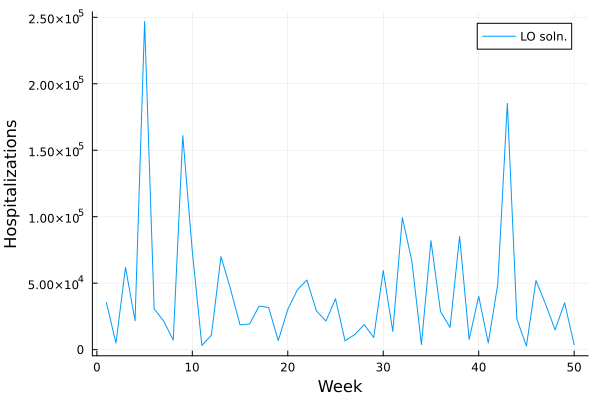

In [17]:
plot(sum(Matrix(Y), dims=2), xlabel="Week", ylabel="Hospitalizations", label="LO soln.")